In [1]:
# Let's keep our notebook clean, so it's a little more readable!
import warnings
warnings.filterwarnings('ignore')

# Predict age from resting state fMRI (rs-fMRI) with [`scikit-learn`](https://scikit-learn.org)

We will integrate what we've learned in the previous sections to extract data from *several* rs-fmri images, and use that data as features in a machine learning model

The dataset consists of children (ages 3-13) and young adults (ages 18-39). We will use rs-fmri data to try to predict who are adults and who are children.

## Load the data

In [2]:
# change this to the location where you want the data to get downloaded
data_dir = './nilearn_data'

# Now fetch the data
from nilearn import datasets
development_dataset = datasets.fetch_development_fmri(
                                                      data_dir=data_dir,
                                                      reduce_confounds = False
                                                    )

data = development_dataset.func
confounds = development_dataset.confounds

 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (4 seconds, 0 min)


How many individual subjects do we have?

In [3]:
#len(data.func)
len(data)

155

## Get Y (our target) and assess its distribution

In [4]:
# Let's load the phenotype data
import pandas as pd

pheno = pd.DataFrame(development_dataset.phenotypic)
pheno.head(40)

,participant_id,Age,AgeGroup,Child_Adult,Gender,Handedness
0,sub-pixar123,27.060000,Adult,adult,F,R
1,sub-pixar124,33.440000,Adult,adult,M,R
2,sub-pixar125,31.000000,Adult,adult,M,R
3,sub-pixar126,19.000000,Adult,adult,F,R
4,sub-pixar127,23.000000,Adult,adult,F,R
5,sub-pixar128,27.000000,Adult,adult,M,R
6,sub-pixar129,23.000000,Adult,adult,F,R
7,sub-pixar130,21.000000,Adult,adult,F,R
8,sub-pixar131,39.000000,Adult,adult,M,R
9,sub-pixar132,22.000000,Adult,adult,F,R


Looks like there is a column labeling children and adults. Let's capture it in a variable

In [5]:
y_ageclass = pheno['Child_Adult']
y_ageclass.head()

0    adult
1    adult
2    adult
3    adult
4    adult
Name: Child_Adult, dtype: object

Let's have a look at the distribution of our target variable

child    122
adult     33
Name: Child_Adult, dtype: int64

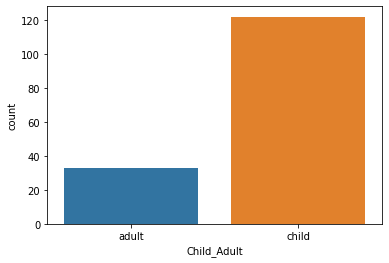

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(y_ageclass)
pheno.Child_Adult.value_counts()

This is very unbalanced -- there seems to be much more children than adults. It is something we can accomodate to a degree when training our model, but it is not within the scope of this tutorial. So let's select an arbitrary subset of the children to match the number of adults. As the 32 adults are at the beginning of the frame, this is easy to do:

In [7]:
data = data[0:66]
pheno = pheno.head(66)
y_ageclass = pheno['Child_Adult']

## Extract features

Here, we are going to use the same techniques we learned in the previous tutorial to extract rs-fmri connectivity features from every subject. Let's reload our atlas, and re-iniate our masker and correlation_measure.

In [8]:
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

# load atlas
multiscale = datasets.fetch_atlas_basc_multiscale_2015(data_dir=data_dir)
atlas_filename = multiscale.scale064

# initialize masker (change verbosity)
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True,
                           memory='nilearn_cache', resampling_target="data",
                           detrend=True, verbose=0)

# initialize correlation measure, set to vectorize
correlation_measure = ConnectivityMeasure(kind='correlation', vectorize=True,
                                         discard_diagonal=True)


Dataset created in ./nilearn_data/basc_multiscale_2015



 ...done. (1 seconds, 0 min)
Extracting data from ./nilearn_data/basc_multiscale_2015/53337d5c408465aa257d35f81c13413b/1861819..... done.


Okay -- now that we have that taken care of, let's load all of the data!

**NOTE**: On a laptop, this might a few minutes.

In [9]:
all_features = [] # here is where we will put the data (a container)

for i,sub in enumerate(data):
    # extract the timeseries from the ROIs in the atlas
    time_series = masker.fit_transform(sub, confounds=confounds[i])
    # create a region x region correlation matrix
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    # add to our container
    all_features.append(correlation_matrix)
    # keep track of status
    print('finished %s of %s'%(i+1,len(data)))

finished 1 of 66


finished 2 of 66


finished 3 of 66


finished 4 of 66


finished 5 of 66


finished 6 of 66


finished 7 of 66


finished 8 of 66


finished 9 of 66


finished 10 of 66


finished 11 of 66


finished 12 of 66


finished 13 of 66


finished 14 of 66


finished 15 of 66


finished 16 of 66


finished 17 of 66


finished 18 of 66


finished 19 of 66


finished 20 of 66


finished 21 of 66


finished 22 of 66


finished 23 of 66


finished 24 of 66


finished 25 of 66


finished 26 of 66


finished 27 of 66


finished 28 of 66


finished 29 of 66


finished 30 of 66


finished 31 of 66


finished 32 of 66


finished 33 of 66


finished 34 of 66


finished 35 of 66


finished 36 of 66


finished 37 of 66


finished 38 of 66


finished 39 of 66


finished 40 of 66


finished 41 of 66


finished 42 of 66


finished 43 of 66


finished 44 of 66


finished 45 of 66


finished 46 of 66


finished 47 of 66


finished 48 of 66


finished 49 of 66


finished 50 of 66


finished 51 of 66


finished 52 of 66


finished 53 of 66


finished 54 of 66


finished 55 of 66


finished 56 of 66


finished 57 of 66


finished 58 of 66


finished 59 of 66


finished 60 of 66


finished 61 of 66


finished 62 of 66


finished 63 of 66


finished 64 of 66


finished 65 of 66


finished 66 of 66


In [10]:
# Let's save the data to disk
import numpy as np

np.savez_compressed('data/MAIN_BASC064_subsamp_features', a=all_features)

In case you do not want to run the full loop on your computer, you can load the output of the loop here!

In [11]:
feat_file = 'data/MAIN_BASC064_subsamp_features.npz'
X_features = np.load(feat_file)['a']

In [12]:
X_features.shape

(66, 2016)

Okay so we've got our features.

We can visualize our feature matrix

Text(0, 0.5, 'subjects')

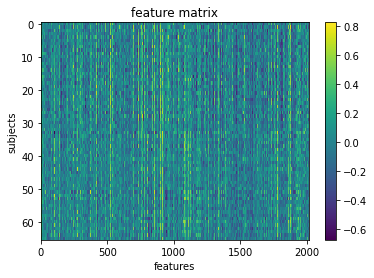

In [13]:
import matplotlib.pyplot as plt

plt.imshow(X_features, aspect='auto', interpolation='nearest')
plt.colorbar()
plt.title('feature matrix')
plt.xlabel('features')
plt.ylabel('subjects')

## Prepare data for machine learning

Here, we will define a "training sample" where we can play around with our models. We will also set aside a "test" sample that we will not touch until the end

We want to be sure that our training and test sample are matched! We can do that with a "stratified split". Specifically, we will stratify by age class.

In [14]:
y_ageclass.shape

(66,)

In [15]:
from sklearn.model_selection import train_test_split

# Split the sample to training/test and
# stratify by age class, and also shuffle the data.

X_train, X_test, y_train, y_test = train_test_split(
                                                    X_features, # x
                                                    y_ageclass, # y
                                                    test_size = 0.2, # 80%/20% split  
                                                    shuffle = True, # shuffle dataset
                                                                    # before splitting
                                                    stratify = y_ageclass, # keep
                                                                           # distribution
                                                                           # of ageclass
                                                                           # consistent
                                                                           # betw. train
                                                                           # & test sets.
                                                    random_state = 123 # same shuffle each
                                                                       # time
                                                                       )

# print the size of our training and test groups
print('training:', len(X_train),
     'testing:', len(X_test))

training: 52 testing: 14


Let's visualize the distributions to be sure they are matched

Text(0.5, 1.0, 'Test')

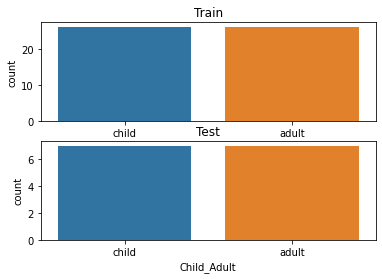

In [16]:
fig,(ax1,ax2) = plt.subplots(2)
sns.countplot(y_train, ax=ax1, order=['child','adult'])
ax1.set_title('Train')
sns.countplot(y_test, ax=ax2, order=['child','adult'])
ax2.set_title('Test')

## Run your first model!

Machine learning can get pretty fancy pretty quickly. We'll start with a very standard classification model called a Support Vector Classifier (SVC).

While this may seem unambitious, simple models can be very robust. And we don't have enough data to create more complex models.

For more information, see this excellent resource:
https://hal.inria.fr/hal-01824205

First, a quick review of SVM!
![](https://docs.opencv.org/2.4/_images/optimal-hyperplane.png)

Let's fit our first model!

In [17]:
from sklearn.svm import SVC
l_svc = SVC(kernel='linear', class_weight='balanced') # define the model

l_svc.fit(X_train, y_train) # fit the model

SVC(class_weight='balanced', kernel='linear')

Well... that was easy. Let's see how well the model learned the data!

We can judge our model on several criteria:
* Accuracy: The proportion of predictions that were correct overall.
* Precision: Accuracy of cases predicted as positive
* Recall: Number of true positives correctly predicted to be positive
* f1 score: A balance between precision and recall

Or, for a more visual explanation...

![](https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg)

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, f1_score

# predict the training data based on the model
y_pred = l_svc.predict(X_train)

# calculate the model accuracy
acc = l_svc.score(X_train, y_train)

# calculate the model precision, recall and f1, all in one convenient report!
cr = classification_report(y_true=y_train,
                      y_pred = y_pred)

# get a table to help us break down these scores
cm = confusion_matrix(y_true=y_train, y_pred = y_pred)

Let's view our results and plot them all at once!

accuracy: 1.0
              precision    recall  f1-score   support

       adult       1.00      1.00      1.00        26
       child       1.00      1.00      1.00        26

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52



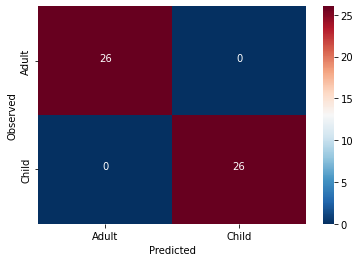

In [19]:
import itertools
from pandas import DataFrame

# print results
print('accuracy:', acc)
print(cr)

# plot confusion matrix
cmdf = DataFrame(cm, index = ['Adult','Child'], columns = ['Adult','Child'])
sns.heatmap(cmdf, cmap = 'RdBu_r')
plt.xlabel('Predicted')
plt.ylabel('Observed')
# label cells in matrix
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j+0.5, i+0.5, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white")

![](https://sebastianraschka.com/images/faq/multiclass-metric/conf_mat.png)

HOLY COW! Machine learning is amazing!!! Almost a perfect fit!

...which means there's something wrong. What's the problem here?

In [20]:
from sklearn.model_selection import cross_val_predict, cross_val_score

# predict
y_pred = cross_val_predict(l_svc, X_train, y_train,
                           groups=y_train, cv=3)
# scores
acc = cross_val_score(l_svc, X_train, y_train,
                     groups=y_train, cv=3)

We can look at the accuracy of the predictions for each fold of the cross-validation

In [21]:
for i in range(len(acc)):
    print('Fold %s -- Acc = %s'%(i, acc[i]))

Fold 0 -- Acc = 0.8888888888888888
Fold 1 -- Acc = 1.0
Fold 2 -- Acc = 1.0


We can also look at the overall accuracy of the model

In [22]:
from sklearn.metrics import accuracy_score
overall_acc = accuracy_score(y_pred = y_pred, y_true = y_train)
overall_cr = classification_report(y_pred = y_pred, y_true = y_train)
overall_cm = confusion_matrix(y_pred = y_pred, y_true = y_train)
print('Accuracy:',overall_acc)
print(overall_cr)

Accuracy: 0.9615384615384616
              precision    recall  f1-score   support

       adult       1.00      0.92      0.96        26
       child       0.93      1.00      0.96        26

    accuracy                           0.96        52
   macro avg       0.96      0.96      0.96        52
weighted avg       0.96      0.96      0.96        52



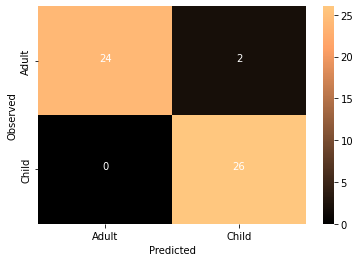

In [23]:
thresh = overall_cm.max() / 2
cmdf = DataFrame(overall_cm, index = ['Adult','Child'], columns = ['Adult','Child'])
sns.heatmap(cmdf, cmap='copper')
plt.xlabel('Predicted')
plt.ylabel('Observed')
for i, j in itertools.product(range(overall_cm.shape[0]), range(overall_cm.shape[1])):
        plt.text(j+0.5, i+0.5, format(overall_cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white")

The model seems to be performing very well. Let's run some null model:

In [24]:
from sklearn.model_selection import permutation_test_score
score, permutation_score, pvalue = permutation_test_score(
    l_svc, X_train, y_train, cv=3, scoring="accuracy",
    n_jobs=2, n_permutations=100)
print(f'accuracy {score}, average permutation accuracy {permutation_score.mean()}, p value {pvalue}')

accuracy 0.9629629629629629, average permutation accuracy 0.48880174291939005, p value 0.009900990099009901


so, as the classes are balanced, the chance level is close to 50%. The model performs significantly higher than chance.

## Tweak your model

It's very important to learn when and where its appropriate to "tweak" your model.

Since we have done all of the previous analysis in our training data, it's find to try different models. But we **absolutely cannot** "test" it on our left out data. If we do, we are in great danger of overfitting.

We could try other models, or tweak hyperparameters, but we are probably not powered sufficiently to do so, and would once again risk overfitting.

But as a demonstration, we could see the impact of "scaling" our data. Certain machine learning algorithms perform better when all the input data is transformed to a uniform range of values. This is often between 0 and 1, or mean centered around with unit variance. We can perhaps look at the performance of the model after scaling the data

In [25]:
# Scale the training data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train_scl = scaler.transform(X_train)

Text(0, 0.5, 'subjects')

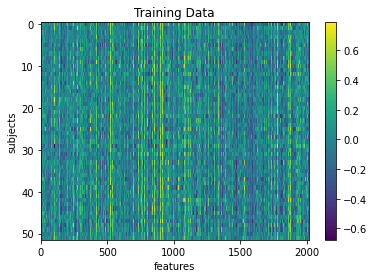

In [26]:
plt.imshow(X_train, aspect='auto', interpolation='nearest')
plt.colorbar()
plt.title('Training Data')
plt.xlabel('features')
plt.ylabel('subjects')

Text(0, 0.5, 'subjects')

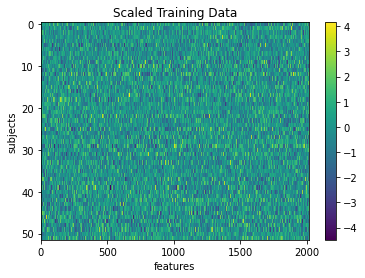

In [27]:
plt.imshow(X_train_scl, aspect='auto', interpolation='nearest')
plt.colorbar()
plt.title('Scaled Training Data')
plt.xlabel('features')
plt.ylabel('subjects')

Accuracy: 0.9615384615384616
              precision    recall  f1-score   support

       adult       1.00      0.92      0.96        26
       child       0.93      1.00      0.96        26

    accuracy                           0.96        52
   macro avg       0.96      0.96      0.96        52
weighted avg       0.96      0.96      0.96        52



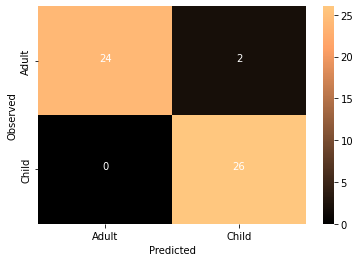

In [28]:
# repeat the steps above to re-fit the model
# and assess its performance

# don't forget to switch X_train to X_train_scl

# predict
y_pred = cross_val_predict(l_svc, X_train_scl, y_train,
                           groups=y_train, cv=3)

# get scores
overall_acc = accuracy_score(y_pred = y_pred, y_true = y_train)
overall_cr = classification_report(y_pred = y_pred, y_true = y_train)
overall_cm = confusion_matrix(y_pred = y_pred, y_true = y_train)
print('Accuracy:',overall_acc)
print(overall_cr)

# plot
thresh = overall_cm.max() / 2
cmdf = DataFrame(overall_cm, index = ['Adult','Child'], columns = ['Adult','Child'])
sns.heatmap(cmdf, cmap='copper')
plt.xlabel('Predicted')
plt.ylabel('Observed')
for i, j in itertools.product(range(overall_cm.shape[0]), range(overall_cm.shape[1])):
        plt.text(j+0.5, i+0.5, format(overall_cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white")

What do you think about the results of this model compared to the non-transformed model?

**Exercise:** Try fitting a new SVC model and tweak one of the many parameters. Run cross-validation and see how well it goes. Make a new cell and type SVC? to see the possible hyperparameters

In [29]:
#l_svc = SVC(kernel='linear') # define the model

## Can our model classify children from adults in completely un-seen data?
Now that we've fit a model we think has possibly learned how to decode childhood vs adulthood based on rs-fmri signal, let's put it to the test. We will train our model on all of the training data, and try to predict the age of the subjects we left out at the beginning of this section.

Because we performed a transformation on our training data, we will need to transform our testing data using the *same information!*

In [30]:
# Notice how we use the Scaler that was fit to X_train and apply to X_test,
# rather than creating a new Scaler for X_test
X_test_scl = scaler.transform(X_test)

And now for the moment of truth!

No cross-validation needed here. We simply fit the model with the training data and use it to predict the testing data

I'm so nervous. Let's just do it all in one cell

accuracy = 1.0
              precision    recall  f1-score   support

       adult       1.00      1.00      1.00         7
       child       1.00      1.00      1.00         7

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14



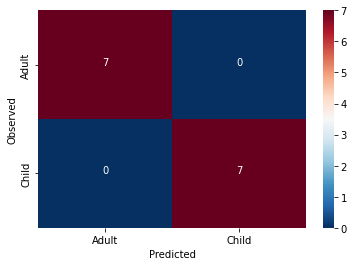

In [31]:
l_svc.fit(X_train_scl, y_train) # fit to training data
y_pred = l_svc.predict(X_test_scl) # classify age class using testing data
acc = l_svc.score(X_test_scl, y_test) # get accuracy
cr = classification_report(y_pred=y_pred, y_true=y_test) # get prec., recall & f1
cm = confusion_matrix(y_pred=y_pred, y_true=y_test) # get confusion matrix

# print results
print('accuracy =', acc)
print(cr)

# plot results
thresh = cm.max() / 2
cmdf = DataFrame(cm, index = ['Adult','Child'], columns = ['Adult','Child'])
sns.heatmap(cmdf, cmap='RdBu_r')
plt.xlabel('Predicted')
plt.ylabel('Observed')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j+0.5, i+0.5, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white")

The model generalized very well! We may have found something in this data which does seem to be systematically related to age ... but what?

## Interpreting model feature importances
Interpreting the feature importances of a machine learning model is a real can of worms. This is an area of active research. Unfortunately, it's hard to trust the feature importance of some models.

You can find a whole tutorial on this subject here:
http://gael-varoquaux.info/interpreting_ml_tuto/index.html

For now, we'll just eschew better judgement and take a look at our feature importances

We can access the feature importances (weights) used my the model

In [32]:
l_svc.coef_

array([[ 0.00095925,  0.00230708, -0.00234671, ..., -0.00168313,
        -0.00091351,  0.0014638 ]])

lets plot these weights to see their distribution better

Text(0, 0.5, 'weight')

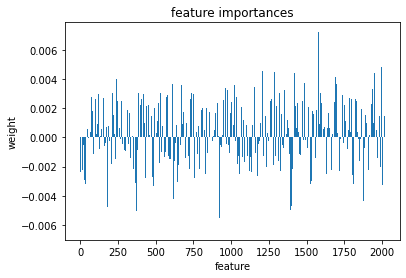

In [33]:
plt.bar(range(l_svc.coef_.shape[-1]),l_svc.coef_[0])
plt.title('feature importances')
plt.xlabel('feature')
plt.ylabel('weight')

Or perhaps it will be easier to visualize this information as a matrix similar to the one we started with

We can use the correlation measure from before to perform an inverse transform

In [34]:
correlation_measure.inverse_transform(l_svc.coef_).shape

(1, 64, 64)

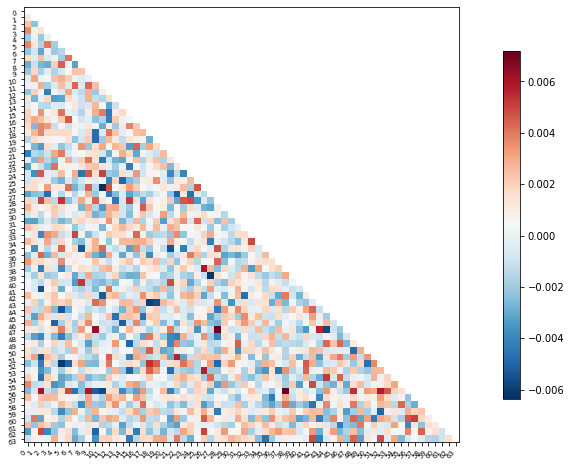

In [35]:
from nilearn import plotting

feat_exp_matrix = correlation_measure.inverse_transform(l_svc.coef_)[0]

plotting.plot_matrix(feat_exp_matrix, figure=(10, 8),  
                     labels=range(feat_exp_matrix.shape[0]),
                     reorder=False,
                    tri='lower')

Let's see if we can throw those features onto an actual brain.

First, we'll need to gather the coordinates of each ROI of our atlas

In [36]:
coords = plotting.find_parcellation_cut_coords(atlas_filename)

And now we can use our feature matrix and the wonders of nilearn to create a connectome map where each node is an ROI, and each connection is weighted by the importance of the feature to the model

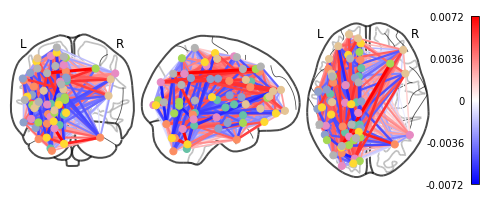

In [37]:
plotting.plot_connectome(feat_exp_matrix, coords, colorbar=True)

Whoa!! That's...a lot to process. Maybe let's threshold the edges so that only the most important connections are visualized

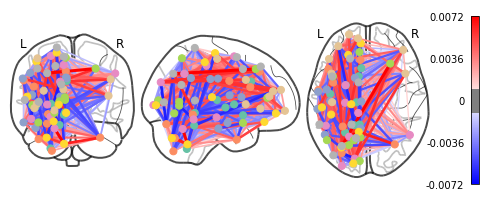

In [38]:
plotting.plot_connectome(feat_exp_matrix, coords, colorbar=True, edge_threshold=0.001)

That's definitely an improvement, but it's still a bit hard to see what's going on.
Nilearn has a new feature that let's use view this data interactively!

In [39]:
plotting.view_connectome(feat_exp_matrix, coords, edge_threshold='90%')

You can choose to open the figure in a browser with the following lines:

In [40]:
# view = plotting.view_connectome(feat_exp_matrix, coords, edge_threshold='90%')
# view.open_in_browser()